## 1. Preview

This tutorial begins with a description of a simple groundwater flow model. By following the instructions that are set out in the following pages, you will:

- Parameterize the model using pilot points.
- Extract model-calculated counterparts to field measurements from model output files.
- Identify certain model-generated numbers as predictions of interest.
- Construct a PEST dataset that enables model history-matching.
- Calibrate the model.
- Explore parameter and predictive uncertainty using linear analysis.
- Generate stochastic hydraulic property fields that sample the prior and posterior probability distributions of model parameters.
- Explore parameter and predictive uncertainty using ensemble methods.
- Explore predictive uncertainty using data space inversion.

The model discussed in this tutorial is simple and runs quickly. This allows for exploration of a range of history-matching and uncertainty analysis options in a short amount of time. Due to the model's simplicity, some PEST setup details receive only limited treatment. However, many of these details are important. For more information, the reader is directed to other tutorials (downloadable from the GMDSI website) and to PEST documentation.

It is important to note that the methods described in this tutorial do not comprise the only way to link PEST/PEST++ to a model. Commercial and free graphical user interfaces provide their own PEST setup alternatives. In addition, FloPy and PyEMU offer a large range of workflow options, as well as tutorials that describe them.

## 2. The Model

### What the Model Does

The model discussed in this tutorial simulates steady-state flow of groundwater through a heterogeneous medium. It is a single-layer model that will be calibrated by adjusting the hydraulic conductivities within its upper (and only) layer. Calibration targets include the heads measured in 12 observation wells.

We will examine the uncertainties of two model predictions:

1. The location of a particle's emergence through the bottom boundary of the synthetic system.
2. The timing of this emergence.

The primary focus will be on the first prediction. It's important to note that the bottom boundary is a fixed head boundary.

Groundwater flow is simulated using MODFLOW 6. Particle movement is simulated using MODPATH 7. The MODFLOW 6 grid is structured; all cells that occupy this structured grid are square with sides of 10 m.

Utility software that accompanies PEST provides many options for construction of PEST-to-model linkages. Some of these options pertain to structured grids, while others pertain to unstructured grids. Some are specific to certain model types (for example MODFLOW-USG or MODFLOW 6) while others are general. In the present case we will take advantage of the structured nature of the model grid. This allows us to set up simple but effective communication pathways between PEST and the model. 
Before doing anything else, we will inspect some of the model’s input and output files. Because PEST and PEST++ are model independent, their interface with the model relies on these files. 

### MODFLOW6

MODFLOW 6 requires a name file named mfsim.nam. This cites other name files for the submodels that MODFLOW 6 must run. If you inspect file mfsim.nam, you will see that MODFLOW 6 runs only one model. This is a groundwater flow model whose name file is rect.nam. Inspect rect.nam. This tells us that the node property flow (i.e. NPF) package input file for this model is rect.npf. It is through this file that we gain access to hydraulic conductivities.

Inspect rect.npf. It is apparent from this file that hydraulic conductivities for layer 1 reside in a file named hk.ref. This makes things very simple. The “OPEN/CLOSE” designation of this file indicates that when MODFLOW 6 wishes to obtain hydraulic conductivities for layer 1, it opens this file, reads its contents, and then closes it. (If necessary, hydraulic properties for other layers can then be read from the same file.)

Inspect file hk.ref. This file contains an array of hydraulic conductivity values. (At the moment, the contents of hk.ref are actually the same as those of reality.ref; the latter file contains the “real” values of hydraulic conductivity that are depicted in Figure 2.1.) In a file of this type, hydraulic conductivities for the top row of the model are read first, those for the second row are read next, etc. (Actually MODFLOW 6 would be happy if all of these numbers were arranged in a single column; all that it requires when reading hydraulic conductivities using the OPEN/CLOSE protocol are that numbers are in the right order, and that each number is separated from its neighbour by a space, comma or line feed.)

It is useful to store other significant arrays in files of their own as well. This allows easy access to these arrays by model-value-adding software. As will be seen shortly, tasks performed by this software may include the production of files that can be read by GIS, plotting and visualisation packages. 
The IDOMAIN array for the present model resides in a file named idomain.inf. A closely-related file is ibound.inf. This also contains an integer array; however, in accordance with older MODFLOW protocols, fixed head cells are denoted by an integer value of -1 in this array. This is not used by our MODFLOW 6 model; however it can be useful for plotting purposes.


We will load the model first using flopy:

In [1]:
#import libraries
import os
import flopy

#set the path
files_dir = os.path.join('.','tutorial_files')

#import the mf6 model
mf6exe = 'mf6.exe'
mf6_which = flopy.which(mf6exe)
sim = flopy.mf6.MFSimulation.load(sim_name='mfsim.nam', exe_name=mf6_which, sim_ws=files_dir)
model = sim.get_model()

#get xcenter and ycenter from the modelgrid
xcenter = model.modelgrid.xcellcenters
ycenter = model.modelgrid.ycellcenters

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package oc...
    loading package chd...
    loading package wel...
  loading ims package rect_model...


Let's run the model one time

In [2]:
#run the model
sim.run_simulation()

FloPy is using the following executable to run the model: C:\Workspace\opaz0002\Software\mf6.4.1\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 09 2022 18:18:37 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither th

(True, [])

### MODPATH 7

MODPATH 7 commences execution by reading a "simulation file". For the present example, this is `rect.mpsim`. This file directs the attention of MODPATH 7 to a name file named `rect.mpnam`. The latter file names other MODPATH 7 input files. Note that these include the MODFLOW 6 output files `rect.hds` and `rect.bud`.

In the present tutorial, we are not interested in MODPATH input files, for none of the parameters that will be adjusted during this workshop are used by MODPATH. However, we are particularly interested in one of its output files, this being its "endpoint file" which, in the present case, is named `rect.endpoint7`.

Now we will load the particle MODPATH 7 simulation file, and then run MODPATH 7.

In [3]:
#load the modpath 7 simulation
mp7exe = 'mpath7.exe'
mp7_which = flopy.which(mp7exe)
print(mp7_which)
mp = flopy.modpath.Modpath7('rect', flowmodel=model, exe_name=mp7_which, model_ws=files_dir)
#run the modpath 7 simulation
mp.run_model()

C:\Workspace\opaz0002\Software\modpath_7_2_001\bin\mpath7.exe
FloPy is using the following executable to run the model: C:\Workspace\opaz0002\Software\modpath_7_2_001\bin\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         1 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Nor

(True, [])

Load the particle pathline and endpoint data

In [4]:
import re
import numpy as np
fpth = os.path.join(files_dir, 'rect.pathline7')
corrected_fpth = fpth + '.corrected'  # Creating a new path for the corrected file

# Step 1 & 2: Read the file and correct any formatting issues
with open(fpth, 'r') as file, open(corrected_fpth, 'w') as corrected_file:
    for line in file:
        # Correcting the format by adding 'e' to match scientific notation
        corrected_line = re.sub(r'(\d)\-(\d)', r'\1e-\2', line)
        corrected_file.write(corrected_line)

# Step 3: Load the corrected file with flopy
p = flopy.utils.PathlineFile(corrected_fpth)
# load the endpoints
fpth = os.path.join(files_dir, 'rect.endpoint7')
e = flopy.utils.EndpointFile(fpth)
tepd = e.get_alldata()  # get all the enpoints
tept = tepd[0][5] #endpoint time
tepl = tepd[0][21] #endpoint location
#print the endpoint time and location
print('True time:', np.round(tept,2))
print('True location:', np.round(tepl,2))



True time: 5094.84
True location: 196.71


Lets look at the model results

c:\Program Files\Anaconda3\envs\prior\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Program Files\Anaconda3\envs\prior\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Program Files\Anaconda3\envs\prior\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


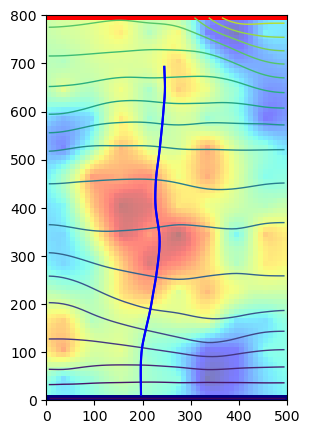

In [5]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=model)
#linecollection = mapview.plot_grid()

#plot hydraulic conductivity
quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)

#plot bcs
quadmesh = mapview.plot_bc("CHD",label='CHD')
quadmesh = mapview.plot_bc("WEL",label='WEL')

#load heads and contour
hds = flopy.utils.HeadFile(os.path.join(files_dir, 'rect.hds'))
head = hds.get_data()
contour_set = mapview.contour_array(head, levels=np.arange(0, 10, 0.5), linewidths=1.)
#plot pathlines

mapview.plot_pathline(p.get_alldata(), layer="all", colors="blue")


## Grid Specification File

Simulators use their own local coordinate systems. However, data that are used for history-matching are associated with real-world coordinates. A linkage must be created between these two coordinate systems. This is done using a “grid specification file”.

A structured grid specification file is particularly easy to build. (The same does not hold true for an unstructured grid specification file.) PEST Groundwater Utilities can read unstructured grid specifications for both MODFLOW-USG and MODFLOW 6 models. In the latter case, specifications can be read from the “GRB file” (i.e., binary grid file) that is written by MODFLOW 6. In the present case, because our model employs a structured grid, we will adopt the simpler option of using an easily prepared text file for structured grid specification.

Note that grid specification files have purposes that extend beyond enablement of PEST/PEST++ linkage to a model. They can also enable communication between a model and software packages that are used for plotting and visualization.

Inspect file `rect.spc`. The first line lists the number of rows and columns (respectively) in the model grid. The second line provides the real-world coordinates of the top left corner of the grid, together with the angle of rotation of the grid row direction counterclockwise from east (in degrees). The DELR and DELC arrays follow; these define cell widths in the row and column directions respectively. This file is easily constructed using a text editor. The DELR and DELC arrays can be copied from a MODFLOW DIS file.

In [6]:
with open(os.path.join(files_dir, 'rect.spc'), 'r') as file:
    spc_file = file.readlines()
    for line in spc_file:
        print(line,end='')

  80  50
 0.0   800.0  0.0
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10.0     10
  10.0 

## 3. Field Measurements

### General

Much (but not all) PEST setup can be automated if certain protocols are adopted for data storage. In this chapter, we outline some of these protocols and put them to use.

### Well Coordinates

In our synthetic example, head measurements are available in 12 observation wells. Each of these wells must have a name (20 characters or less for PEST-suite programs, but more than this if you are using PyEMU). Their names, together with their coordinates and the model layer numbers that they tap, must be supplied in a “bore coordinates file”. For our simple example, `wells.crd` is such a file. It is reproduced in the figure below.

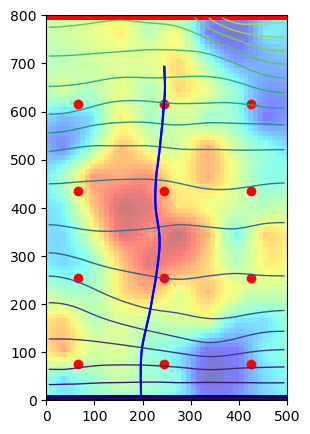

In [7]:
with open(os.path.join(files_dir, 'wells.crd'), 'r') as file:
    crd_file = file.readlines()
file.close()
x = []
y = []
for line in crd_file:
    x.append(float(line.split()[1]))
    y.append(float(line.split()[2]))

fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=model)
#linecollection = mapview.plot_grid()

#plot hydraulic conductivity
quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)

#plot bcs
quadmesh = mapview.plot_bc("CHD",label='CHD')
quadmesh = mapview.plot_bc("WEL",label='WEL')

#load heads and contour
hds = flopy.utils.HeadFile(os.path.join(files_dir, 'rect.hds'))
head = hds.get_data()
contour_set = mapview.contour_array(head, levels=np.arange(0, 10, 0.5), linewidths=1.)
#plot pathlines

mapview.plot_pathline(p.get_alldata(), layer="all", colors="blue")

#plot the wells
plt.scatter(x, y, marker='o', color='red', label='Wells')

Field measurements can be stored in a "site sample file". See file `observ.smp`. It is reproduced below.


In [8]:
obs = []
with open(os.path.join(files_dir, 'observ.smp'), 'r') as file:
    ss_file = file.readlines()
    for line in ss_file:
        print(line,end='')
        obs.append(float(line.split()[3])) #we will use this later for DSI

 WELL01      02/01/2020    00:00:00     5.74724
 WELL02      02/01/2020    00:00:00     5.69616
 WELL03      02/01/2020    00:00:00     5.49199
 WELL04      02/01/2020    00:00:00     4.09190
 WELL05      02/01/2020    00:00:00     3.92014
 WELL06      02/01/2020    00:00:00     4.05991
 WELL07      02/01/2020    00:00:00     2.59369
 WELL08      02/01/2020    00:00:00     3.25979
 WELL09      02/01/2020    00:00:00     2.97368
 WELL10      02/01/2020    00:00:00     1.12417
 WELL11      02/01/2020    00:00:00     1.20361
 WELL12      02/01/2020    00:00:00     1.19256


In the present example, there is only one measurement associated with each well. These are all piezometric heads (in metres). We presume that the standard deviation of measurement error is about 10 cm (i.e. 0.1 m). This will become important later when weights are assigned to these measurements.

In more complex history-matching contexts, site sample files can associate many measurements with each site. Where this is done, these measurements must be grouped by site and (for each site) provided in order of increasing date and time. The date protocol can be either “dd/mm/yyyy” or “mm/dd/yyyy”. Any PEST Groundwater Utility program which reads a site sample file also reads a file named `settings.fig` which must be present in the folder from which it is run. The contents of this file tell it which of these date protocols to respect. They also inform it whether the first line of a MODFLOW-compatible data array contains an NCOL/NROW header. File `settings.fig` for our example case is reproduced in the following figure.


In [9]:
with open(os.path.join(files_dir,'settings.fig'),'r') as file:
    fig_file = file.readlines()
    for line in fig_file:
        print(line)

colrow=no

date=dd/mm/yyyy



If you store your field data in a complex site sample file that houses many field measurements taken at many times, and if you are unsure of whether its protocol is correct, you can check the file using program `SMPCHEK`.

### Model-Generated Field Measurements

MODFLOW 6 records the heads that it calculates in a large binary file. In the present case, this file is named `rect.hds`. MODFLOW 6 records this file in double precision. Previous versions of MODFLOW recorded it in single precision.


Linkage of model coordinates to real-world coordinates was described above. A similar linkage must be made between simulation times and the times at which field measurements were made. According to the site sample file that is displayed in Figure 3.2, a single set of field measurements was made on 2nd January 2020. According to the time discretisation file `rect.tdis`, the steady state model runs for one day. To facilitate temporal interpolation of model outputs to measurement times, we will specify that execution of the model commences on 1st January 2020.

Synthesis of model-generated counterparts to observations from the contents of a MODFLOW-generated, double precision, binary, system state file can be performed using the `MOD2OBS_DBL` utility program. This undertakes temporal and spatial interpolation from model output times and model cell centres to the times and locations of field measurements. Run `MOD2OBS_DBL`, responding to its prompts as follows:


In [10]:
cwd = os.getcwd()
os.chdir(files_dir)
!mod2obs_dbl < mod2obs.in
os.chdir(cwd)

 
 Program MOD2OBS writes a bore sample file of model-generated heads over 
   time, interpolated to the sites and times supplied in an existing bore 
   sample file.
 
 Note: This program reads a MODFLOW or MT3D unformatted file. Sometimes there 
 are problems in reading files of this type due to incompatibilities between 
 different FORTRAN compiliers. If there are any such problems please contact
 johndoherty@ozemail.com.au and I will send you an alternative copy of this 
 program.

 Enter name of grid specification file:   - grid specifications read from file rect.spc
 Enter name of bore coordinates file:   - 12 bores and coordinates read from bore coordinates file wells.crd
 Enter name of bore listing file:   - 12 bores read from bore listing file wells.crd
 Enter name of bore sample file: 
 Enter name of unformatted model-generated file:  Is this a MODFLOW or MT3D file?  [f/t]:  Enter inactive threshold value for numbers in this file:  Enter time units used by model (yr/day/hr/mi

## 5. Pilot Points

### Disposition of Pilot Points

Inspect the file `hk.pts`. This file provides the coordinates of 104 pilot points which are arranged on a regular grid throughout the model domain. Their locations are shown in many of the figures that appear later in this document. The columns of `hk.pts` contain respectively: 

- Pilot point names;
- Eastings;
- Northings;
- Zone numbers;
- Hydraulic conductivity values.

Where pilot points are used as a model parameterization device, assignment of hydraulic properties to cells that comprise a model grid becomes a two-step process. First, hydraulic properties are assigned to pilot points; then, these properties are interpolated to the model grid. The latter task is performed by `PLPROC`.

`PLPROC` can read data pertaining to pilot points from a variety of file types. In this example, we employ that which is exemplified by `hk.pts` because this file can also be used by the `PPCOV` utility for easy generation of pilot-point-pertinent covariance matrices. (Note that `PLPROC` can also build covariance matrices. However, in this workshop, we confine our use of `PLPROC` to spatial interpolation.)


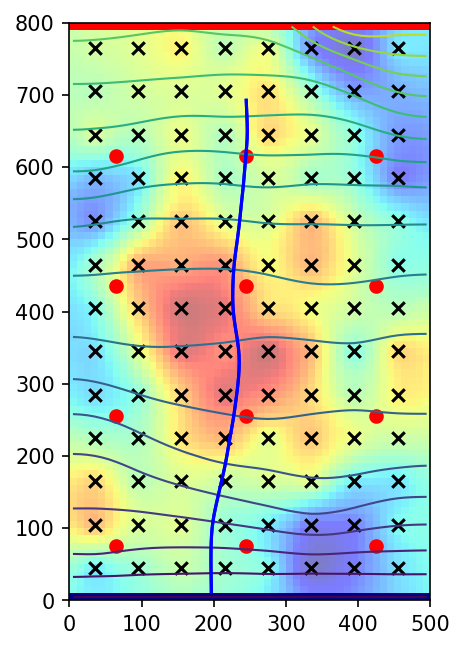

In [11]:
x_pp = []
y_pp = []
with open(os.path.join(files_dir, 'hk.pts'), 'r') as file:
    pts_file = file.readlines()
    for line in pts_file:
        x_pp.append(float(line.split()[1]))
        y_pp.append(float(line.split()[2]))

fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=model)
#linecollection = mapview.plot_grid()

#plot hydraulic conductivity
quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)

#plot bcs
quadmesh = mapview.plot_bc("CHD",label='CHD')
quadmesh = mapview.plot_bc("WEL",label='WEL')

#load heads and contour
hds = flopy.utils.HeadFile(os.path.join(files_dir, 'rect.hds'))
head = hds.get_data()
contour_set = mapview.contour_array(head, levels=np.arange(0, 10, 0.5), linewidths=1.)
#plot pathlines

mapview.plot_pathline(p.get_alldata(), layer="all", colors="blue")

#plot the wells
plt.scatter(x, y, marker='o', color='red')
plt.scatter(x_pp, y_pp, marker='x', color='black')

### The PLPROC Input File

PLPROC can create parameterisation schemes of arbitrary complexity for single or multilayer models that employ structured or unstructured grids. It does this by following a series of processing directives. These directives are encapsulated in a script. In the present case, the script resides in file `plproc.dat`.

PLPROC bases many of its operations on three entity types. The first of these is a CLIST. A CLIST contains a set of two- or three-dimensional coordinates. These coordinates can pertain to a structured or unstructured grid, to a set of pilot points, or to linear or polygonal shapes that define structural overlay features. 

CLISTs are parents to both PLISTs and SLISTs. A PLIST associates an array of real numbers with the coordinates of its parent CLIST, while an SLIST associates an array of integers with elements of a CLIST. PLISTs can host hydraulic properties and model parameters, while SLISTs can be used to control selective assignment and processing of these entities.


In [12]:
with open(os.path.join(files_dir, 'plproc.dat'), 'r') as file:
    plproc_file = file.readlines()
    for line in plproc_file:
        print(line,end='')

# Read a specification file for a structured grid. Create a model CLIST.

mf_cl = read_mf_grid_specs(file="rect.spc")

# Read pilot point locations and values. Create a pilot point CLIST.

pp_cl = read_list_file(dimensions=2,                  &
                       plist='pp_hk';column=5,        &
                       id_type='character',           &
                       file='hk.pts')

# Calculate interpolation factors.

calc_kriging_factors_2d(target_clist=mf_cl,                      &
                        source_clist=pp_cl,                      &
                        file=factors.dat,                        &
                        variogram=exponential,                   &
                        a=150.0,                                 &
                        kriging=ordinary,                        &
                        min_points=1,max_points=12,search_radius=1e15)

# Create a model-based PLIST to hold HK values.

mf_hk=new_plist(reference_clist=mf_cl,value=1

### Running PLPROC

In [13]:
cwd = os.getcwd()
os.chdir(files_dir)
!plproc.exe plproc.dat
os.chdir(cwd)


PLPROC Version 4.0. Watermark Numerical Computing.
 
Reading and storing contents of PLPROC script file plproc.dat...
Processing commands in PLPROC script file...
 
> mf_cl=read_mf_grid_specs(file="rect.spc")
> pp_cl=read_list_file(dimensions=2,plist='pp_hk';column=5,id_type='cha...
> calc_kriging_factors_2d(target_clist=mf_cl,source_clist=pp_cl,file=fa...
> mf_hk=new_plist(reference_clist=mf_cl,value=1.0)
> mf_hk=pp_hk.krige_using_file(file='factors.dat',transform="log")
> write_model_input_file(template_file='hk_ref.tpl',model_input_file='h...
 
End of file: no more commands to process.


As you can see from the screen, PLPROC carries out the directives that are encapsulated in its script. In doing so, it writes two files. One of these is the interpolation factor file `factors.dat`. The other is the model input file `hk.ref`. The array contained in the latter file is now full of ones. This is because hydraulic conductivities assigned to all pilot points in file `hk.pts` are equal to 1.0. 

Edit `plproc.dat`. Now that we have calculated kriging factors, we do not need to calculate them again. Comment out the function that does this. See below.

In [14]:
lindex = 0
with open(os.path.join(files_dir, 'plproc.dat'), 'r') as file:
    plproc_file = file.readlines()
    #look for the line that contains calc_kriging_factors_2d
    for i,line in enumerate(plproc_file):
        if 'calc_kriging_factors_2d' in line:
            lindex = i
            break
file.close()
#write the same 'plproc.dat' file discarding 'calc_kriging_factors_2d' line and 6 lines after that
with open(os.path.join(files_dir, 'plproc1.dat'), 'w') as file:
    for i,line in enumerate(plproc_file):
        if i < lindex or i > lindex + 6:
            file.write(line)

cwd = os.getcwd()
os.chdir(files_dir)
!plproc.exe plproc1.dat
os.chdir(cwd)



PLPROC Version 4.0. Watermark Numerical Computing.
 
Reading and storing contents of PLPROC script file plproc1.dat...
Processing commands in PLPROC script file...
 
> mf_cl=read_mf_grid_specs(file="rect.spc")
> pp_cl=read_list_file(dimensions=2,plist='pp_hk';column=5,id_type='cha...
> mf_hk=new_plist(reference_clist=mf_cl,value=1.0)
> mf_hk=pp_hk.krige_using_file(file='factors.dat',transform="log")
> write_model_input_file(template_file='hk_ref.tpl',model_input_file='h...
 
End of file: no more commands to process.


## 6. Preparing a PEST Input Dataset

### A Template File
The model that is the focus of our current attention employs only one parameter type, namely hydraulic conductivity. Values of hydraulic conductivity are assigned to pilot points. As we have already seen, these values reside in file `hk.pts`. A template of this file comprises an essential element of the PEST-model interface.

A template file has already been prepared for you; see file `hk.tpl`. Pilot point parameters are named `k_ppt1`, `k_ppt2`…`k_ppt104`. Construction of this file from `hk.pts` is obvious.



In [15]:
with open(os.path.join(files_dir, 'hk.tpl'), 'r') as file:
    pts_file = file.readlines()
    for line in pts_file:
        print(line,end='')

ptf $
ppt1       35.0    765.0      1       $ k_ppt1       $
ppt2       95.0    765.0      1       $ k_ppt2       $
ppt3      155.0    765.0      1       $ k_ppt3       $
ppt4      215.0    765.0      1       $ k_ppt4       $
ppt5      275.0    765.0      1       $ k_ppt5       $
ppt6      335.0    765.0      1       $ k_ppt6       $
ppt7      395.0    765.0      1       $ k_ppt7       $
ppt8      455.0    765.0      1       $ k_ppt8       $
ppt9       35.0    705.0      1       $ k_ppt9       $
ppt10      95.0    705.0      1       $ k_ppt10      $
ppt11     155.0    705.0      1       $ k_ppt11      $
ppt12     215.0    705.0      1       $ k_ppt12      $
ppt13     275.0    705.0      1       $ k_ppt13      $
ppt14     335.0    705.0      1       $ k_ppt14      $
ppt15     395.0    705.0      1       $ k_ppt15      $
ppt16     455.0    705.0      1       $ k_ppt16      $
ppt17      35.0    645.0      1       $ k_ppt17      $
ppt18      95.0    645.0      1       $ k_ppt18      $
ppt1

### A PEST Control File

We will import a set of customized low-level wrappers of PEST utilities to facilitate PEST file creation. These functions are included in the python library called PEST_utils

In [16]:
import PEST_utils

ModuleNotFoundError: No module named 'PEST_utils'

In [91]:
#create initial pst file

obs_file = 'observ.smp'
sim_file = 'model.smp'

tpl_files = ['hk.tpl']
in_files = ['hk.pts']

model_cmd_filename = 'model.bat'

PEST_utils.pestprep1b(files_dir,"temp1.pst", obs_file, sim_file,"_", "heads", tpl_files,in_files,model_cmd_filename)

with open(os.path.join(files_dir, "temp1.pst"), 'r') as file:
    plproc_file = file.readlines()
    for line in plproc_file:
        print(line,end='')

pcf
* control data
restart  estimation
      104      12       1       0       1
     1     1 single  point  1   0   0
 10.0  -3.0  0.3  0.03  10  999
 10.0  10.0  0.001
 0.1  noaui
 30  0.005  4  4  0.005  4
 1  1  1
* singular value decomposition
    1
   104   5.0e-7
    0
* parameter groups
 k     relative    0.01  0.0  switch  2.0 parabolic
* parameter data
 k_ppt1       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt2       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt3       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt4       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt5       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt6       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt7       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt8       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt9       log  factor   1.0  1.0e-10  1.0e10 k     1.0  0.0  1
 k_ppt10      log  factor   1.0 

Update parameter groups (to update DERINC in this case)

In [92]:
# Parameter groups are modified and parameter groups variables are setup
upargroups = [["k_ppt", "relative", 0.01, 0.0, "switch", 2.0, "parabolic",1.00E-05,0.5,'smaller']]

PEST_utils.pstpargroup(files_dir,"temp1.pst","temp2.pst",upargroups)

'temp2.pst'

Modify parameter data section

In [93]:
par_data = {}
par_data['k_ppt']=['log','factor',1.0,0.01,100.0,'k_ppt',1.0,0,1]
PEST_utils.pstpardata(files_dir,"temp2.pst",par_data,'temp3.pst')

'temp3.pst'

Now we modify the pst file to add the predictions (this is done manually here)

In [94]:
#now we modify the pst file to add the part_time and part_east predictions
#also we change noptmax to 50

with open(os.path.join(files_dir,"temp3.pst"),'r') as f:
    lines = f.readlines()
f.close()

with open(os.path.join(files_dir,"temp4.pst"),'w') as f:
    for line in range(len(lines)):
        if line == 3:
            l_sp = lines[line].split()
            npar = l_sp[0]
            nobs = int(l_sp[1])
            f.write(npar +' '+str(nobs+2)+' 1 0 3\n')
        elif line == 4:
            f.write('     1     2 single  point  1   0   0\n')
        elif line == 8:
            f.write('50  0.005  4  4  0.005  4\n')
        elif str.strip(lines[line]) == 'heads':
            f.write(lines[line])
            f.write('time\n')
            f.write('distance\n')
        elif '_well12_1' in lines[line]:
            f.write(lines[line])
            f.write('part_time       0.000000      0.0  time\n')
            f.write('part_east       0.000000      0.0  distance\n')
        elif '* model input/output' in lines[line]:
            f.write(lines[line])
            f.write(lines[line+1])
            f.write(lines[line+2])
            f.write('endpoint.ins rect.endpoint7\n')
            f.write(lines[line+3])
            break
        else:
            f.write(lines[line])
f.close()

Now we will adjust observation weights equal to the inverse of measurement noise (0.1 m)

In [95]:
PEST_utils.pstobswt(files_dir,'temp4.pst',"time", 10.0, "case.pst")

'case.pst'

We can run PESTCHEK to verify all is good

In [96]:
cwd = os.getcwd()
os.chdir(files_dir)
!pestchek case.pst
os.chdir(cwd)


PESTCHEK Version 17.5. Watermark Numerical Computing.

Errors ----->
No errors encountered.

Warnings ----->
No warnings.


### “The Model”

Obviously, the model that PEST runs must include more than MODFLOW 6 and MODPATH 7. It must include PLPROC at the front end and MOD2OBS_DBL at the back end. These commands have been included in file `model.bat`. It is reproduced below. 


In [97]:
with open(os.path.join(files_dir,"model.bat"),'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line,end='')

@echo off
Rem ###################################
Rem Some intermediate files are deleted.
Rem ###################################

del hk.ref > nul
del rect.hds > nul
del rect.bud > nul

Rem ###################################
Rem Now the actual model is run
Rem ###################################

plproc plproc.dat > nul
mf6 > nul
mpath7 rect.mpsim > nul
mod2obs_dbl < mod2obs.in > nul




PEST setup is now complete. However, depending on whether we are doing calibration, linear uncertainty analysis, nonlinear uncertainty analysis, data space inversion, or some other form of model-based data processing, certain additions must be made to the current PEST setup. These, however, are comparatively minor.

## 7. Model Calibration

### Regularised Inversion
"Model calibration" is another term for "regularised inversion". This process aims for parameter uniqueness by identifying a parameter set that theoretically minimizes the potential for incorrect predictions. Ideally, predictions from a calibrated model should be close to the center of their posterior probability distribution. In this context, "preferred value" Tikhonov regularisation will be employed to achieve parameter uniqueness.

### Adding Regularisation to a PEST Control File
To incorporate regularisation into the PEST control file we've constructed, we'll use the ADDREG utility.


In [98]:
cwd = os.getcwd()
os.chdir(files_dir)
!addreg2 case.pst case_r.pst 12
os.chdir(cwd)


 ADDREG2 version 17.5. Watermark Numerical Computing.
 - file case.pst read ok.
 - file case_r.pst written ok.


In [99]:
with open(os.path.join(files_dir,"case_r.pst"),'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line,end='')

pcf
* control data
restart regularisation
     104      14       1     104       4
1     2 single  point  1   0   0
10.0  -3.0  0.3  0.03  10  999
 10.0  10.0  0.001
 0.1  noaui
50  0.005  4  4  0.005  4
 1  1  1
* singular value decomposition
    1
   104   5.0e-7
    0
* parameter groups
k_ppt        relative     0.01         0.0          switch       2.0          parabolic    1e-05        0.5          smaller
* parameter data
k_ppt1        log           factor        1.0           0.01          100.0         k_ppt         1.0           0             1
k_ppt2        log           factor        1.0           0.01          100.0         k_ppt         1.0           0             1
k_ppt3        log           factor        1.0           0.01          100.0         k_ppt         1.0           0             1
k_ppt4        log           factor        1.0           0.01          100.0         k_ppt         1.0           0             1
k_ppt5        log           factor        1.0          

### Construction of a Covariance Matrix
Tikhonov regularisation not only specifies a preferred parameter condition. It also specifies the manner in which departures from that condition should arise during history-matching. In order to respect the fact that hydraulic conductivity exhibits spatial correlation , a covariance matrix will now be built to accompany the prior information equations through which preferred parameter values are expressed. This covariance matrix will be based on a variogram. 

Use ADDREG2 to adjust PHIMLIM and PHIMACCEPT

In [100]:
#build a covariance matrix using an exponential variogram model
vsill = 0.2
vrange = 200
par_geostats = {"k_ppt":['hk.pts',"log",vsill,vrange]}
cov_file = PEST_utils.ppcov(files_dir,par_geostats,param_file='param.unc')

#add the covariacne matrix to the pst file
PEST_utils.addcovmat(files_dir,'case_r.pst',cov_file,'case1.pst')

'case1.pst'

We can run PESTCHEK one last time to verify all is good

In [101]:
cwd = os.getcwd()
os.chdir(files_dir)
!pestchek case1.pst
os.chdir(cwd)


PESTCHEK Version 17.5. Watermark Numerical Computing.

Errors ----->
No errors encountered.

Warnings ----->
No warnings.


### Running PEST

In [102]:
PEST_utils.start_workers('case1.pst',files_dir,num_workers=20,worker_root="..",exec='pest_hp',cleanup=True)

### Running PEST with optimized parameters

In [103]:
cwd = os.getcwd()
os.chdir(files_dir)
!parrep case1.par case1.pst case1_sol.pst 0
!pest case1_sol.pst
os.chdir(cwd)


PARREP Version 17.5. Watermark Numerical Computing.

Reading parameter value file case1.par ----->
Data for 104 parameters read from file case1.par.

Reading file case1.pst and writing file case1_sol.pst ----->
File case1_sol.pst written ok.

PEST Version 17.5. Watermark Numerical Computing.

PEST is running in regularisation mode.

PEST run record: case case1_sol
(See file case1_sol.rec for full details.)

Model command line: 
model.bat

Running model .....

   Running model 1 time....
   Current regularisation weight factor                     =   1.0000    
   Current value of measurement objective function          =   12.229    
   Current value of regularisation objective function       =   2.4256    

   Sum of squared weighted residuals (ie phi)               =   14.655    
   Contribution to phi from observation group "heads"       =   12.229    
   Contribution to phi from observation group "time"        =   0.0000    
   Contribution to phi from observation group "distance"

The process cannot access the file because it is being used by another process.


Now we can plot the calibrated field and results

Predicted time: 6902.73 True time: 3256.17
Predicted location: 225.28 True location: 206.78


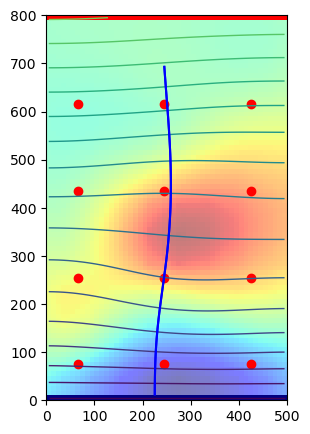

In [105]:
import re
import numpy as np
fpth = os.path.join(files_dir, 'rect.pathline7')
corrected_fpth = fpth + '.corrected'  # Creating a new path for the corrected file

# Step 1 & 2: Read the file and correct any formatting issues
with open(fpth, 'r') as file, open(corrected_fpth, 'w') as corrected_file:
    for line in file:
        # Correcting the format by adding 'e' to match scientific notation
        corrected_line = re.sub(r'(\d)\-(\d)', r'\1e-\2', line)
        corrected_file.write(corrected_line)

# Step 3: Load the corrected file with flopy
p = flopy.utils.PathlineFile(corrected_fpth)
# load the endpoints
fpth = os.path.join(files_dir, 'rect.endpoint7')
e = flopy.utils.EndpointFile(fpth)
cepd = e.get_alldata()  # get all the enpoints
cept = cepd[0][5] #endpoint time
cepl = cepd[0][21] #endpoint location
#print the endpoint time and location
print('Predicted time:', np.round(cept,2), 'True time:', np.round(tept,2))
print('Predicted location:', np.round(cepl,2), 'True location:', np.round(tepl,2))

fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=model)
#linecollection = mapview.plot_grid()

#plot hydraulic conductivity
quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)

#plot bcs
quadmesh = mapview.plot_bc("CHD",label='CHD')
quadmesh = mapview.plot_bc("WEL",label='WEL')

#load heads and contour
hds = flopy.utils.HeadFile(os.path.join(files_dir, 'rect.hds'))
head = hds.get_data()
contour_set = mapview.contour_array(head, levels=np.arange(0, 10, 0.5), linewidths=1.)
#plot pathlines

mapview.plot_pathline(p.get_alldata(), layer="all", colors="blue")

#plot the wells
plt.scatter(x, y, marker='o', color='red')

## 8. Linear uncertainty Analysis

### Identifiability

We can run IDENTPAR to calculate parameter identifiability. First we need to remove regularization from the pst file

In [106]:
cwd = os.getcwd()
os.chdir(files_dir)
!subreg1 case1.pst case1_nr.pst
!jco2jco case1.pst case1_nr.pst
!identpar case1_nr.pst 12 null null ident.par /s
os.chdir(cwd)


 SUBREG1 version 17.5. Watermark Numerical Computing.

 - file case1.pst read ok.
 - file case1_nr.pst written ok.

JCO2JCO Version 17.5. Watermark Numerical Computing.
- file case1.pst read ok.
- file case1.jco read ok.
- file case1_nr.pst read ok.
- file case1_nr.jco written ok.


IDENTPAR Version 17.5. Watermark Numerical Computing.


- reading PEST control file case1_nr.pst....
- file case1_nr.pst read ok.

- reading Jacobian matrix file case1_nr.jco....
- file case1_nr.jco read ok.

- forming XtQX matrix....
- carrying out singular value decomposition....

- writing parameter identifiability file....
- file ident.par written ok.


Now we can plot identifiabilities in a map

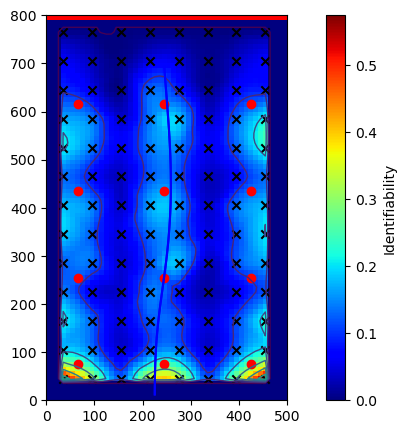

In [107]:
#load ident.par file
ident = []
with open(os.path.join(files_dir, 'ident.par'), 'r') as file:
    ident_file = file.readlines()
    for i in range(1,len(ident_file)):
        #get identifiability from second last column
        ident.append(float(ident_file[i].split()[-2]))

xy_pp = list(zip(x_pp,y_pp))
xy_m = list(zip(xcenter.flatten(),ycenter.flatten()))

#x_pp, and y_pp are the points where the parameter is estimated
#perform an interpolation to get the parameter values at all points of the model grid

from scipy.interpolate import griddata
#interpolate the parameter values
Zg = griddata(xy_pp, np.array(ident), xy_m, method='cubic',fill_value=0.0)
Zg = Zg.reshape((80,50))

fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=model)
#linecollection = mapview.plot_grid()

identifiability = mapview.plot_array(Zg, cmap='jet')
#plot contours of identifiability, add labels to contour lines
contour_set = mapview.contour_array(Zg, levels=np.arange(0, 1, 0.1), linewidths=1.)
plt.colorbar(identifiability, label='Identifiability')


#plot bcs
quadmesh = mapview.plot_bc("CHD",label='CHD')
quadmesh = mapview.plot_bc("WEL",label='WEL')

#plot pathlines

mapview.plot_pathline(p.get_alldata(), layer="all", colors="blue")

#plot the wells
plt.scatter(x, y, marker='o', color='red')
plt.scatter(x_pp, y_pp, marker='x', color='black')

### Predictive uncertainty

We can run PREDUNC1 to calculate relative parameter uncertainty variance reductions.

First we need to generate a sensitivity vector for the predictions of interest

In [108]:
cwd = os.getcwd()
os.chdir(files_dir)
!jrow2vec case1_nr.jco part_time part_time.jco
!jrow2vec case1_nr.jco part_east part_east.jco
os.chdir(cwd)



JROW2VEC version 17.5. Watermark Numerical Computing.

- reading Jacobian matrix file case1_nr.jco...
- Jacobian matrix file case1_nr.jco read ok.

- writing file part_time.jco...
- file part_time.jco written ok.


JROW2VEC version 17.5. Watermark Numerical Computing.

- reading Jacobian matrix file case1_nr.jco...
- Jacobian matrix file case1_nr.jco read ok.

- writing file part_east.jco...
- file part_east.jco written ok.


Now we will generate the input responses for PREDUNC1

In [109]:
with open(os.path.join(files_dir, 'part_time.in'), 'w') as file:
    file.write('case1_nr.pst\n') #pst file
    file.write('1.0\n') #observation reference variance
    file.write('param.unc\n') #parameter uncertainty file
    file.write('part_time.jco\n') #jacobian matrix of prediction
    file.write('1\n') #equation

cwd = os.getcwd()
os.chdir(files_dir)
!predunc1 < part_time.in
os.chdir(cwd)






 PREDUNC1 Version 17.5. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file:  Enter name of predictive sensitivity matrix file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file case1_nr.pst....
 - file case1_nr.pst read ok.

 - reading Jacobian matrix file case1_nr.jco....
 - file case1_nr.jco read ok.

 - reading predictive sensitivity matrix file part_time.jco....
 - file part_time.jco read ok.

 - reading parameter uncertainty file param.unc....
 - covariance matrix file k_ppt_cov.dat read ok.
 - parameter uncertainty file param.unc read ok.

 - computing pre-calibration predictive uncertainty....
 - forming XtC-1(e)X matrix....
 - inverting C(p) matrix....
 - inverting [XtC-1(e)X +

In [110]:
with open(os.path.join(files_dir, 'part_east.in'), 'w') as file:
    file.write('case1_nr.pst\n') #pst file
    file.write('1.0\n') #observation reference variance
    file.write('param.unc\n') #parameter uncertainty file
    file.write('part_east.jco\n') #jacobian matrix of prediction
    file.write('1\n') #equation

cwd = os.getcwd()
os.chdir(files_dir)
!predunc1 < part_east.in
os.chdir(cwd)


 PREDUNC1 Version 17.5. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file:  Enter name of predictive sensitivity matrix file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file case1_nr.pst....
 - file case1_nr.pst read ok.

 - reading Jacobian matrix file case1_nr.jco....
 - file case1_nr.jco read ok.

 - reading predictive sensitivity matrix file part_east.jco....
 - file part_east.jco read ok.

 - reading parameter uncertainty file param.unc....
 - covariance matrix file k_ppt_cov.dat read ok.
 - parameter uncertainty file param.unc read ok.

 - computing pre-calibration predictive uncertainty....
 - forming XtC-1(e)X matrix....
 - inverting C(p) matrix....
 - inverting [XtC-1(e)X +

## 9. Sampling the Posterior
### Obtaining the Posterior Covariance Matrix
Using the PREDUNC7 utility, we will create a parameter uncertainty file in which posterior (i.e. post-calibration) uncertainties are specified. We will name this file post_param.unc. This will complement the prior (i.e. pre-calibration) parameter uncertainty file param.unc which we previously built.


In [111]:
with open(os.path.join(files_dir, 'predunc7.in'), 'w') as file:
    file.write('case1_nr.pst\n') #pst file
    file.write('1.0\n') #observation reference variance
    file.write('param.unc\n') #parameter uncertainty file
    file.write('post_cov.dat\n') #jacobian matrix of prediction
    file.write('post_param.unc\n') #posterior parameter unc file
    file.write('1\n') #equation

cwd = os.getcwd()
os.chdir(files_dir)
!predunc7 < predunc7.in
os.chdir(cwd)


 PREDUNC7 Version 17.5. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file: 
 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file case1_nr.pst....
 - file case1_nr.pst read ok.

 - reading Jacobian matrix file case1_nr.jco....
 - file case1_nr.jco read ok.

 - reading parameter uncertainty file param.unc....
 - covariance matrix file k_ppt_cov.dat read ok.
 - parameter uncertainty file param.unc read ok.
 - forming XtC-1(e)X matrix....
 - inverting prior C(p) matrix....
 - inverting [XtC-1(e)X + C-1(p)] matrix....
 - writing file post_cov.dat...
 - file post_cov.dat written ok

Now we can sample the distribution with RANDPAR assuming the mean is the calibrated parameter field and the covariance matrix is the updated one generated with PREDUNC7

In [112]:
with open(os.path.join(files_dir, 'randpar.in'), 'w') as file:
   file.write('case1_nr.pst\n') #pst file
   file.write('n\n') #lognormal distribution
   file.write('e\n') #existing parameter values as mean values
   file.write('y\n') #respect parameter ranges
   file.write('post_param.unc\n') #parameter uncertainty file
   file.write('\n') #covariance matrix file
   file.write('random\n') #parameter ordering file
   file.write('4\n') #number of parameter value files
   file.write('\n') #parameter value file

cwd = os.getcwd()
os.chdir(files_dir)
!randpar < randpar.in
os.chdir(cwd)


 RANDPAR Version 17.5. Watermark Numerical Computing.

 Enter name of existing PEST control file:  - 104 parameters read from file case1_nr.pst.
 - 104 of these are adjustable.

 Use (log)normal or (log)uniform distrib for param generation? [n/u]:  Compute means as existing param values or range midpoints? [e/m]:  Respect parameter ranges? [y/n]: 
 Enter name of parameter uncertainty file:  - covariance matrix file post_cov.dat read ok.
 - parameter uncertainty file post_param.unc read ok.

 Enter name of parameter ordering file (<Enter> if none): 
 Enter filename base for parameter value files:  How many of these files do you wish to generate? 
 Enter integer random number seed (<Enter> if default):  - file random1.par written ok.
 - file random2.par written ok.
 - file random3.par written ok.
 - file random4.par written ok.


Plot these four parameter fields

C:\Users\opaz0002\AppData\Local\Temp\ipykernel_23488\3347650537.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


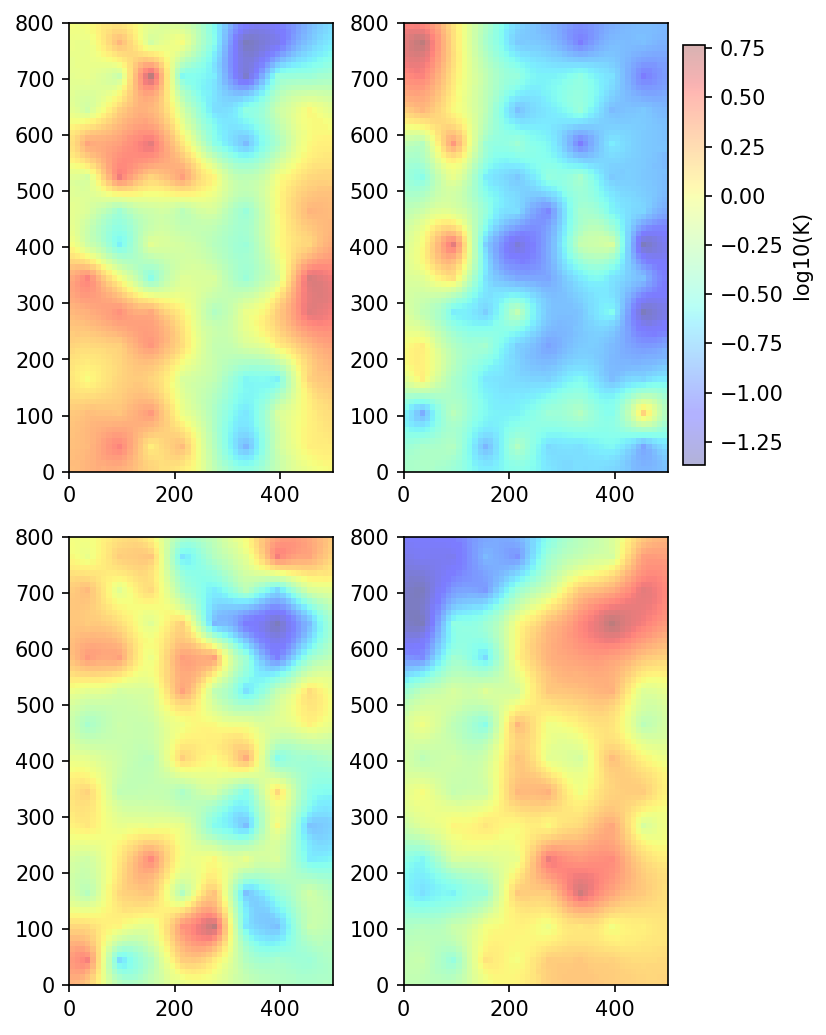

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(5, 7), dpi=150)
cbar_ax = fig.add_axes([0.92, 0.55, 0.03, 0.4])
cwd = os.getcwd()
os.chdir(files_dir)
for i,iax in enumerate(ax.flatten()):
    par_file = 'random' + str(i+1) + '.par'
    os.system('parrep '+par_file+' case1_nr.pst case1_nr_sol_temp.pst 0')
    os.system('pest case1_nr_sol_temp.pst')
    mapview = flopy.plot.PlotMapView(model=model, ax=iax)
    #linecollection = mapview.plot_grid()

    #plot hydraulic conductivity
    quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)
fig.colorbar(quadmesh, cax=cbar_ax, orientation='vertical', label='log10(K)')
os.chdir(cwd)
fig.tight_layout()

fig.subplots_adjust(right=0.9)

## 11. Enforcing Calibration Constraints – PESTPP-IES

## Introduction
We will now use PESTPP-IES to obtain samples of the posterior parameter probability distribution. Where parameter numbers are high, and where posterior parameter uncertainty is null-space-dominated, this method can be extremely model-run-efficient compared to other methods. 
## Running PESTPP-IES
We do not need to calibrate a model prior to using PESTPP-IES, as the processes of model calibration and sampling of the posterior parameter probability distribution are one and the same. (Note, however, that the performance of PESTPP-IES can often be enhanced if it follows model calibration.) 

So copy the original PEST control file case.pst to a new PEST control file named case7.pst.


In [114]:
cwd = os.getcwd()
os.chdir(files_dir)
!copy case.pst case7.pst
os.chdir(cwd)

        1 file(s) copied.


Set NOPTMAX = 5 and add PESTPP-IES options

In [115]:
with open(os.path.join(files_dir,"case7.pst"),'r') as f:
    lines = f.readlines()
f.close()

with open(os.path.join(files_dir,"case8.pst"),'w') as f:
    for line in range(len(lines)):
        if line == 8:
            f.write('5  0.005  4  4  0.005  4\n')
        else:
            f.write(lines[line])
    #add PESTPP-IES settings
    f.write('++ ies_num_reals(40)\n')
    f.write('++ parcov(param.unc)\n')
    f.write('++ ies_subset_size(2)\n')
    #f.write('++ ies_reg_factor(0.1)\n')
f.close()

Run PESTPP-IES in parallel

In [116]:
PEST_utils.start_workers('case8.pst',files_dir,num_workers=20,worker_root="..",exec='pestpp-ies',cleanup=True)

Inspect the objective function evolution

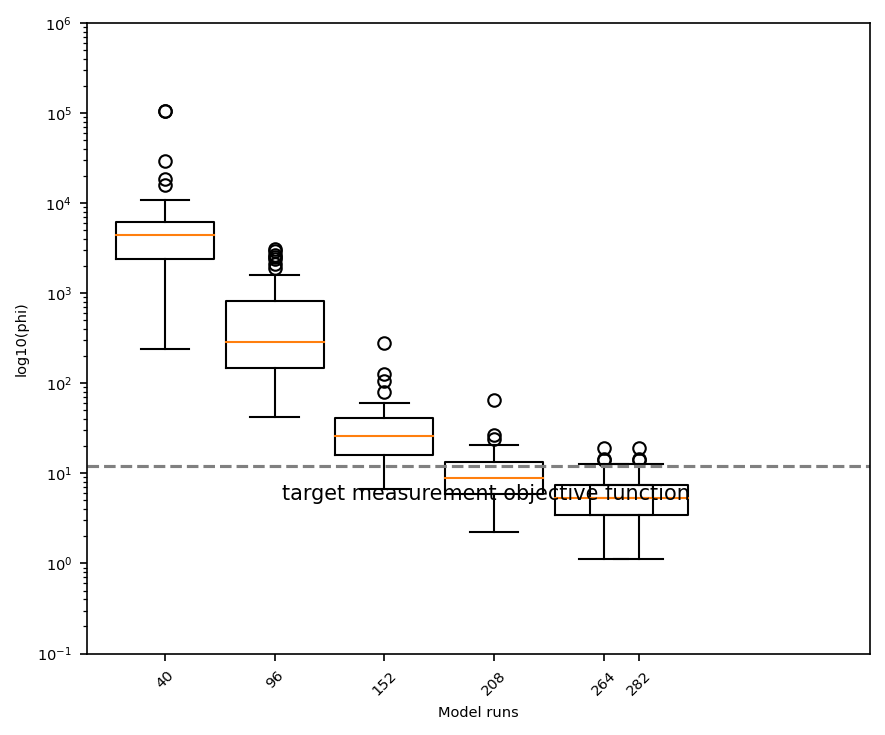

In [120]:
import pandas as pd
#plot phi
phi_df = pd.read_csv(os.path.join(files_dir,'case8.phi.meas.csv'))
runs = np.array(phi_df['total_runs'])
phi_df.dropna(how='all', axis=1, inplace=True)
phi_df.drop(columns=['iteration','total_runs','mean','standard_deviation','min','max'],inplace=True)
#phi_df = np.log10(phi_df)
phi_t = phi_df.T

phi_t_values = phi_t.values
niter = len(phi_t.columns)

mask = ~np.isnan(phi_t_values)
filtered_data = [d[m] for d, m in zip(phi_t_values.T, mask.T)]

fig, ax = plt.subplots(figsize=(6,5),dpi=150)
ax.boxplot(filtered_data,positions=runs,widths=50)
ax.set_xlim([0,400])


ax.axhline(y=12,linestyle='dashed',color='grey')
ax.text(100,5,'target measurement objective function',fontsize=10)

ax.set_yscale('log')
#ax.grid(which='both',axis='y')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim([0.1,1000000])
ax.set_xlabel('Model runs',fontsize=7)
#rotate the x-axis labels
plt.xticks(rotation=45)
ax.set_ylabel('log10(phi)',fontsize=7)
fig.tight_layout()

Evaluate predictive uncertainty of particle arrival time

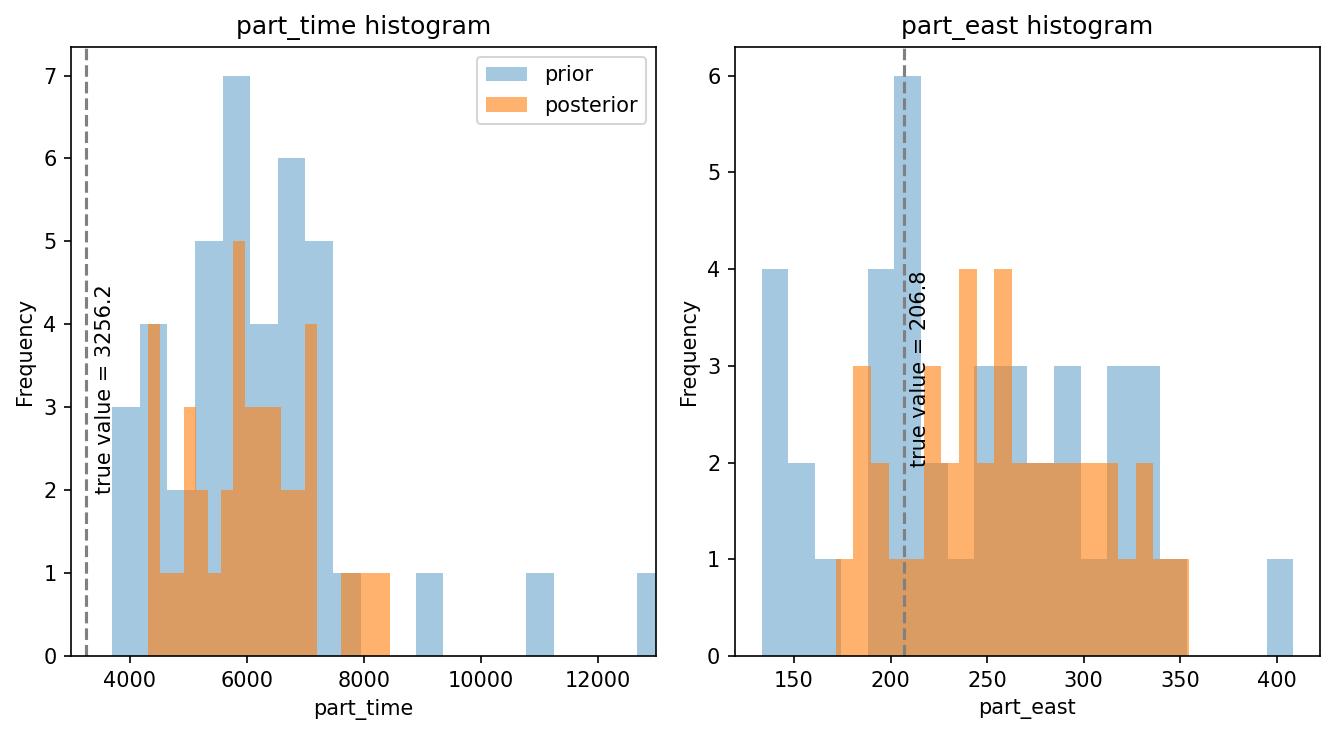

In [121]:
#load the prior_obs, and post_obs file
prior_obs_df = pd.read_csv(os.path.join(files_dir,'case8.0.obs.csv'))
post_obs_df = pd.read_csv(os.path.join(files_dir,'case8.5.obs.csv'))
#filter the column name 'part_time'
prior_part_time = prior_obs_df['part_time']
post_part_time = post_obs_df['part_time']
#filter the column name 'part_east'
prior_part_east = prior_obs_df['part_east']
post_part_east = post_obs_df['part_east']
fig, ax = plt.subplots(1, 2, figsize=(9, 5), dpi=150)
#plot histogram
ax[0].hist(prior_part_time,bins=20,alpha=0.4,label='prior')
ax[0].hist(post_part_time,bins=20,alpha=0.6,label='posterior')
ax[0].legend()
ax[0].set_xlabel('part_time')
ax[0].set_ylabel('Frequency')
ax[0].set_title('part_time histogram')
#add a vertical dashed line with the true value
ax[0].axvline(3256.2,linestyle='dashed',color='grey')
ax[0].text(3400,2,'true value = '+str(3256.2),fontsize=10,rotation=90)
ax[0].set_xlim([3000,13000])
#plot histogram
ax[1].hist(prior_part_east,bins=20,alpha=0.4,label='prior')
ax[1].hist(post_part_east,bins=20,alpha=0.6,label='posterior')
ax[0].legend()
ax[1].set_xlabel('part_east')
ax[1].set_ylabel('Frequency')
ax[1].set_title('part_east histogram')
#add a vertical dashed line with the true value
ax[1].axvline(206.8,linestyle='dashed',color='grey')
ax[1].text(210,2,'true value = '+str(206.8),fontsize=10,rotation=90)
fig.tight_layout()


We can also explore some parameter fields

The process cannot access the file because it is being used by another process.
The process cannot access the file because it is being used by another process.
The process cannot access the file because it is being used by another process.
The process cannot access the file because it is being used by another process.
C:\Users\opaz0002\AppData\Local\Temp\ipykernel_23488\4061427199.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


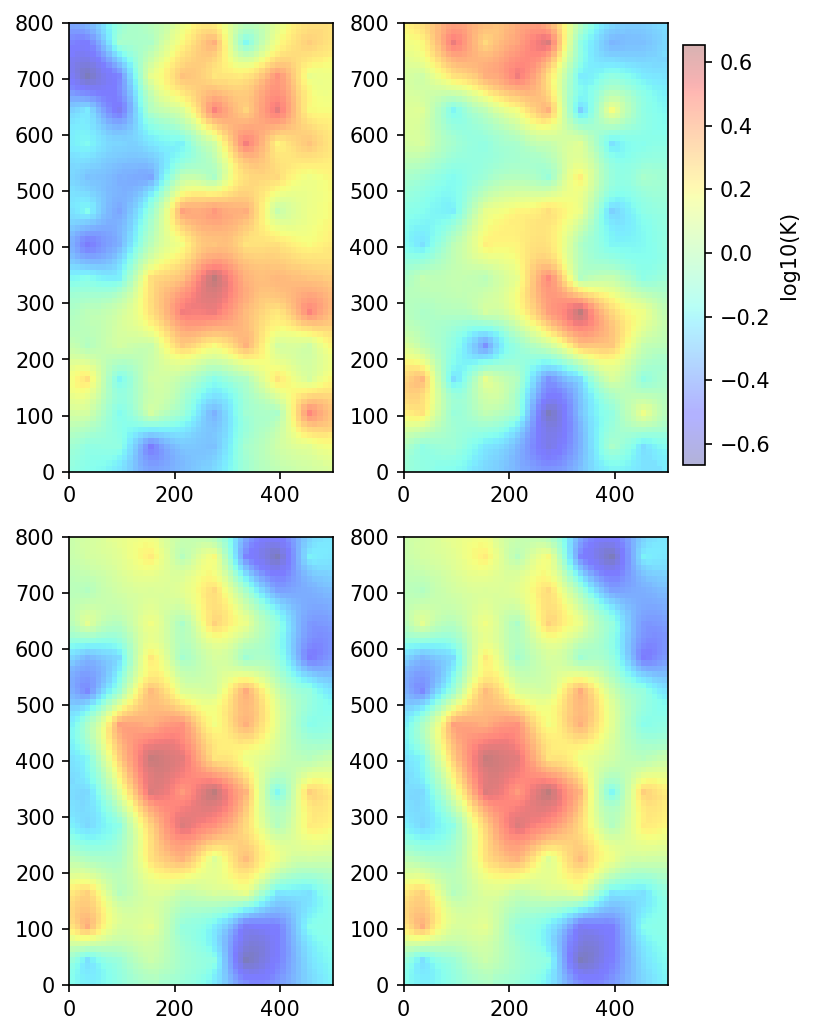

In [123]:
fig, ax = plt.subplots(2, 2, figsize=(5, 7), dpi=150)
cbar_ax = fig.add_axes([0.92, 0.55, 0.03, 0.4])

#load the par file
obs_df = pd.read_csv(os.path.join(files_dir,'case8.5.par.csv'))

#select four random realizations from 1 to 100
realizations = [0,5,35,39]

cwd = os.getcwd()
os.chdir(files_dir)

for i,iax in enumerate(ax.flatten()):
    realization = realizations[i]
    #create input file to run csv2par
    with open('csv2par.in','w') as file:
        file.write('case8.5.par.csv\n')
        file.write('r\n')
        file.write(str(realization)+'\n')
        file.write('case8.par\n')
    f.close()

    !csv2par < csv2par.in > nul
    !parrep case8.par case7.pst case7_sol.pst 0 > nul
    !pest case7_sol.pst > nul

    mapview = flopy.plot.PlotMapView(model=model, ax=iax)
    #linecollection = mapview.plot_grid()

    #plot hydraulic conductivity
    quadmesh = mapview.plot_array(np.log10(model.npf.k.array), cmap='jet', alpha=0.3)
fig.colorbar(quadmesh, cax=cbar_ax, orientation='vertical', label='log10(K)')
os.chdir(cwd)
fig.tight_layout()

fig.subplots_adjust(right=0.9)    

os.chdir(cwd)

## 12. Data Space Inversion
### Introduction
Data space inversion (DSI) allows exploration of the posterior distribution of model predictions without the need to explore the posterior distribution of model parameters. It does this by building a surrogate model based on principle component analysis (PCA) of the covariance matrix between model outputs that correspond to field measurements on the one hand, and predictions of interest on the other hand. These predictions are then conditioned by real world measurements of system behaviour.
The model that is used in the present workshop runs quickly, so there is little to be gained by using DSI. However, if a model is big and cumbersome and runs slowly, DSI can make the difference between being able to undertake predictive uncertainty analysis or not. Furthermore, a big, complex model such as this does not even need to have clearly-defined parameters. It can be populated by random, geostatistically-based hydraulic property fields.
### Building the DSI Model
In its simplistic form, DSI require us to build a statistical correlation model, using model outputs presumably derived from model runs using parameter realizations sampled from the prior

We will use the pydream library to obtain the posterior of DSI parameters

We can calculate the empirical covariance matrix of model outputs

$$ C = \frac{1}{\N-1} \mathbf{X} \mathbf{X}^T $$

where:

- $\mathbf{X} = \mathbf{o} - \mathbf{o_{prior}}$
- $\mathbf{o}$ represents model outputs simulated by the DSI model
- $\mathbf{o_{prior}}$ is the prior estimate of model outputs, i.e, the mean.

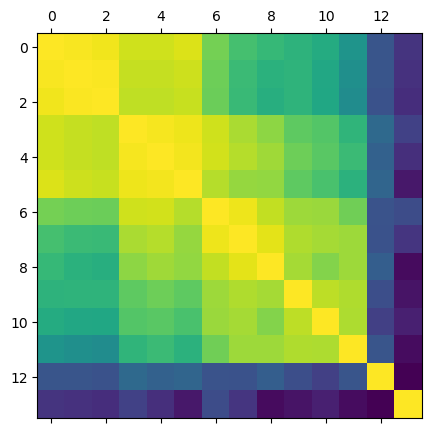

In [125]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#we will use the same model outputs initially created for the PESTPP-IES analysis
#prior_obs_df
files_dir = os.path.join('.','tutorial_files')
prior_obs_df = pd.read_csv(os.path.join(files_dir,'case8.0.obs.csv'))
#drop the first column
prior_obs_df.drop(columns=['real_name'],inplace=True)
#convert the dataframe to a numpy array
d_full = prior_obs_df.values.T
#calculate the mean of d_full
d_full_mean = np.mean(d_full,axis=1)

#calculate the X matrix (d_full-d_full_mean)
X = d_full - d_full_mean[:,None]
#normalize by the standard deviation (given we have different units)
std_X = np.std(X,axis=1)
X = X/std_X[:,None]

eCOV = X@X.T/(X.shape[1]-1)

#plot the eCOV matrix
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
cax = ax.matshow(eCOV)

With DSI we generate a linear correlation model

$$\mathbf{o_{DSI}} = \mathbf{o_{prior}} + \mathbf{\phi} \mathbf{z} $$

where:

- $\mathbf{\phi} = US$ , which encapsulates the relationship between model outputs.
- Matrices U and S are calculated as SVD of $\frac{1}{\sqrt{N-1}} \mathbf{X}$.
- $\mathbf{z}$ is the vector of 'DSI parameters', with a standard normal prior.

In practice, our linear correlation model dimension is reduced using an energy level based on the singular values of the S matrix. This is the same as filtering 'patterns' of variability in the data (as PCA).

Lets calculate the maximum number of singular values, or DSI parameters, given an energy level of 99%

In [127]:
#calculate the SVD of X/np.sqrt(n-1)
U, s, V = np.linalg.svd(X/np.sqrt(d_full.shape[1]-1),full_matrices=False)

#calculate the square of the singular values
s2 = s**2
#define total energy
total_energy = np.sum(s2)
cum_energy = np.cumsum(s2)

#we need to define the required level of energy
el = 0.995

#calculate the number of modes that capture el of the total energy
max_sv = np.sum(cum_energy < el*total_energy) + 1

#print the number of modes
print('Number of modes that capture ',el*100,'% of the energy: ',max_sv)

Number of modes that capture  99.5 % of the energy:  9


Lets generate realizations of $\mathbf{o_{DSI}}$

Text(0.5, 1.0, 'Simulated data for travel time prediction')

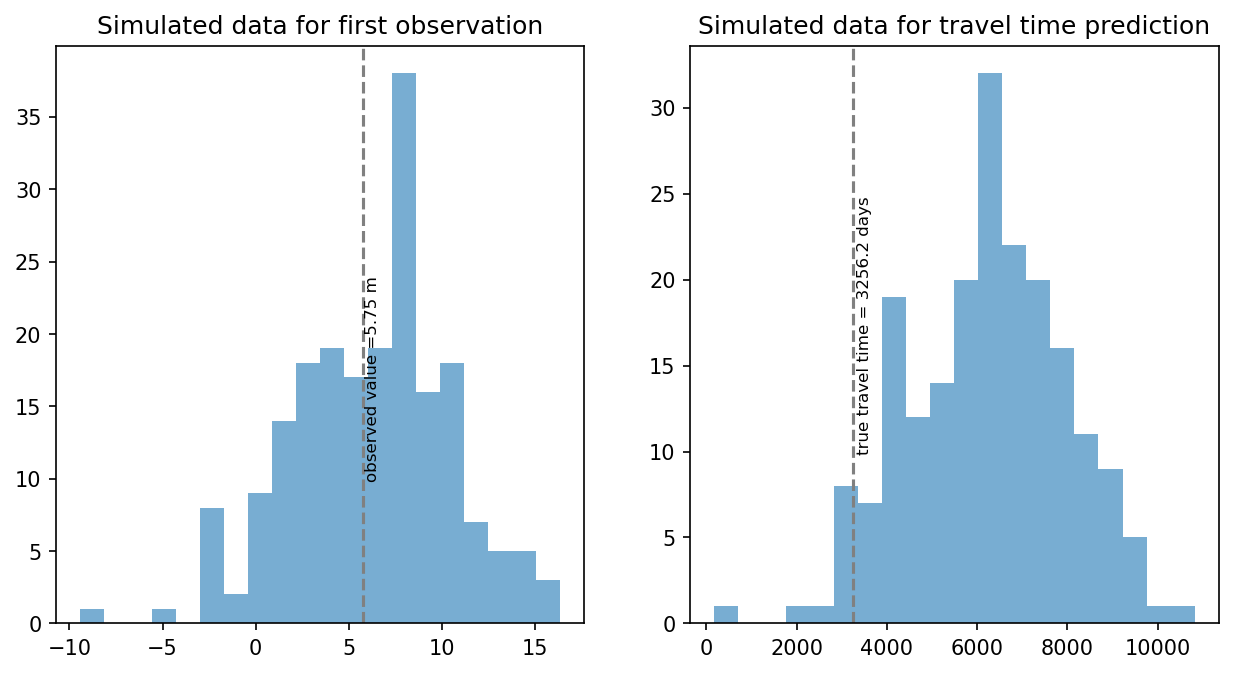

In [128]:
#calculate the truncated phi (tphi)
phi = U@np.diag(s)
tphi = phi[:, :max_sv]

#generate 100 random realizations of z
z = np.random.normal(0,1,(max_sv,200))

#calculate simulated data using DSI correlation model
sim_data = tphi@z*std_X[:,None]+np.mean(d_full,axis=1)[:,None]

#plot the simulated data for first observation adn time travel prediction
fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=150)
hist1 = ax[0].hist(sim_data[0,:],bins=20,alpha=0.6,label='simulated data')
#add vertical line with obs[0] value
ax[0].axvline(obs[0],linestyle='dashed',color='grey')
ax[0].text(obs[0]+0.1,10,'observed value ='+str(np.round(obs[0],2))+' m',fontsize=8,rotation=90)
ax[0].set_title('Simulated data for first observation')
hist2 = ax[1].hist(sim_data[12,:],bins=20,alpha=0.6,label='simulated data')
#add vertical line with true value
ax[1].axvline(3256.2,linestyle='dashed',color='grey')
ax[1].text(3350,10,'true travel time = 3256.2 days',fontsize=8,rotation=90)
ax[1].set_title('Simulated data for travel time prediction')

Let's fit 'DSI parameters' using MCMC. We will run DSI.py

Import DSI results

In [129]:
files_dir = os.path.join('.','tutorial_files')
dsi_results = np.load(os.path.join(files_dir,'dsi_results.npy'))
dsi_results.shape

(14, 7500)

Lets plot some DSI results

Text(3350, 100, 'true travel time = 3256.2 days')

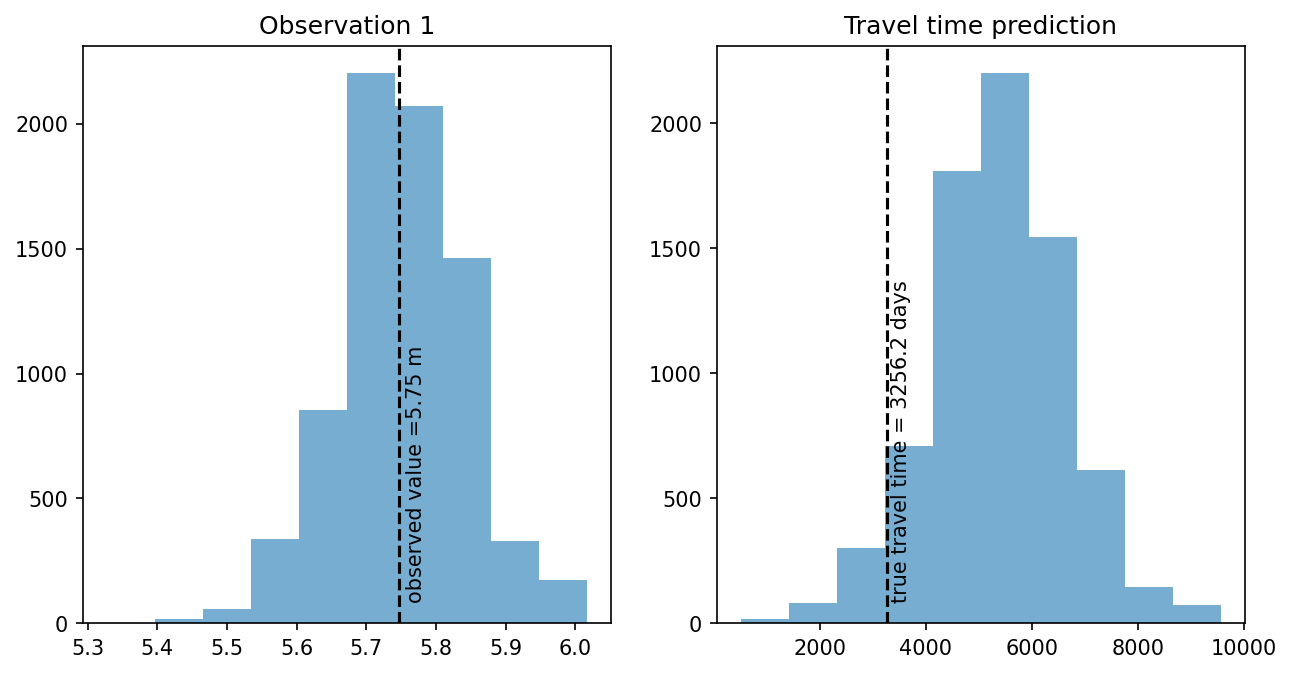

In [130]:
fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=150)
ax[0].hist(dsi_results[0,:],alpha=0.6)
ax[0].set_title('Observation 1')
#add vertical line with obs[0] value
ax[0].axvline(obs[0],linestyle='dashed',color='black')
ax[0].text(obs[0]+0.01,100,'observed value ='+str(np.round(obs[0],2))+' m',fontsize=10,rotation=90)
ax[1].hist(dsi_results[12,:],alpha=0.6)
ax[1].set_title('Travel time prediction')
ax[1].axvline(3256.2,linestyle='dashed',color='black')
ax[1].text(3350,100,'true travel time = 3256.2 days',fontsize=10,rotation=90)